In [21]:
import pandas as pd

# Data Loading

In [22]:
from api.data_handler import DataHandler

# Creation of a DataHandler Object
data_handler = DataHandler(['target', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'id'])

# Number of different Datasets
datasets_number = 3

# Lists of DataFrames
df_train : list[pd.DataFrame] = []
df_test  : list[pd.DataFrame] = []

# Load the Training/Test sets into pandas DataFrames
for i in range(datasets_number):
    df_train.append(data_handler.load_data(f'data/monks/monks-{i+1}.train'))
    df_test.append(data_handler.load_data(f'data/monks/monks-{i+1}.test'))

    # Print the head of the loaded data
    print(df_train[i].head())
    print(df_test[i].head())

     target  col1  col2  col3  col4  col5  col6       id
NaN       1     1     1     1     1     3     1   data_5
NaN       1     1     1     1     1     3     2   data_6
NaN       1     1     1     1     3     2     1  data_19
NaN       1     1     1     1     3     3     2  data_22
NaN       1     1     1     2     1     2     1  data_27
     target  col1  col2  col3  col4  col5  col6      id
NaN       1     1     1     1     1     1     1  data_1
NaN       1     1     1     1     1     1     2  data_2
NaN       1     1     1     1     1     2     1  data_3
NaN       1     1     1     1     1     2     2  data_4
NaN       1     1     1     1     1     3     1  data_5
     target  col1  col2  col3  col4  col5  col6       id
NaN       0     1     1     1     1     2     2   data_4
NaN       0     1     1     1     1     4     1   data_7
NaN       0     1     1     1     2     1     1   data_9
NaN       0     1     1     1     2     1     2  data_10
NaN       0     1     1     1     2  

# Data Split

In [23]:
# Lists of data
x_train : list[pd.DataFrame] = []
y_train : list[pd.DataFrame] = []
x_test  : list[pd.DataFrame] = []
y_test  : list[pd.DataFrame] = []

# Split data into TR set and TS set
for i in range(datasets_number):

    # Saving the splitted TR set data into the lists
    x, y = data_handler.split_data(data=df_train[i], target_col='target', drop_cols=['target', 'id'])
    x_train.append(x)
    y_train.append(y)

    # Saving the splitted TS set data into the lists
    x, y = data_handler.split_data(df_test[i], target_col='target', drop_cols=['target', 'id'])
    x_test.append(x)
    y_test.append(y)


# 1-Hot Encoding

In [24]:
# Applies the 1-Hot Encoding to the "x" data
for i in range(datasets_number):
    x_train[i] = data_handler.one_hot_encoding(x_train[i])
    x_test[i]  = data_handler.one_hot_encoding(x_test[i])

    # Print of the data modified
    print(f"Monk {i+1} [TRAIN]: " + str(x_train[i].shape))
    print(f"Monk {i+1} [TEST]: " + str(x_test[i].shape))

Monk 1 [TRAIN]: (124, 17)
Monk 1 [TEST]: (432, 17)
Monk 2 [TRAIN]: (169, 17)
Monk 2 [TEST]: (432, 17)
Monk 3 [TRAIN]: (122, 17)
Monk 3 [TEST]: (432, 17)


# Grid Search parameters

In [25]:
# Parameters' space for Grid Search (1 for each Dataset)
param_space = {
       1: {
        'hidden_units': [2, 3, 4],
        'patience': [15, 30],
        'learning_rate': [0.3, 0.4],
        'batch_size': [2, 4, 6],
        'nesterov': ["T", "F"],
        'epochs': [240, 340, 450],
        'momentum': [0.6, 0.7, 0.8]
    },
    0: {
        'hidden_units': [3, 4, 5],
        'patience': [15, 30],
        'factor_lr_dec': [0.5, 1],
        'step_decay': [500, 1000, 1500],
        'learning_rate': [0.9, 0.8, 0.7],
        'batch_size': [10, 15, 30, 60], 
        'epochs': [180, 250, 350],
        'momentum': [0.6, 0.7, 0.8],
        'nesterov': ["T", "F"],
    },
    2: {
        'hidden_units': [2, 3],
        'patience': [10,15,30],
        'factor_lr_dec': [0.5, 1],
        'step_decay': [500, 1000, 1500],
        'learning_rate': [float(i/100) for i in range(1,10)],
        'batch_size': [7, 8, 9, 32, 64],
        'epochs': [int(350+epochs) for epochs in range(0,50,10)],
        'weight_decay': [float(i/1000) for i in range(1,10)],
        'momentum': [float(i/1000) for i in range(10,90,5)] + [float(i/100) for i in range(10,90,5)],
        'nesterov': ["T", "F"]
    }
}

# Model Selection

## Best Hyperparameters Research

In [26]:
from sklearn.model_selection import StratifiedKFold
from api.binary_nn import BinaryNN

# Creation of a BinaryNN objct for each dataset
nn: list[BinaryNN] = []

# Different values per dataset
trials_list = [40, 30, 50]
k_values = [5, 5, 5]
n_hidden_layers_list = [1, 1, 1]

# Search of the best Hyperparameters to each Training set
for dataset_i in range(datasets_number):
    X = x_train[dataset_i].values
    y = y_train[dataset_i].values
    k = k_values[dataset_i]

    # K-fold Cross-validation
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Computes and Stores all the parameters combinations
    data_handler.set_params_combinations(params=param_space[dataset_i])

    params_combinations = data_handler.get_params_combinations()

    # For each iteration we choose the hyperparameters and we use them with K-fold CV
    for trial, params in enumerate(params_combinations):

        # Creation of the Neural Network object
        nn_i = BinaryNN(params=params, monk_i=dataset_i+1, trial=trial+1)

        # For each K-fold returns the indexes of the data splitted in: <X_train,y_train> and <X_val,y_val>
        for train_index, val_index in kfold.split(X, y):
            x_kfold_train, x_kfold_val = X[train_index], X[val_index]
            y_kfold_train, y_kfold_val = y[train_index], y[val_index]

            # Building the model
            nn_i.create_model(n_hidden_layers=n_hidden_layers_list[dataset_i])

            # Training the model
            nn_i.fit(
                x_train=x_kfold_train,
                y_train=y_kfold_train,
                x_val=x_kfold_val,
                y_val=y_kfold_val
            )

            # Evaluating the model
            nn_i.evaluate(
                x_train=x_kfold_train,
                y_train=y_kfold_train,
                x_val=x_kfold_val,
                y_val=y_kfold_val
            )

        # Case of first append
        if len(nn) == dataset_i:
            nn.append(nn_i)

        # Print the results of this trial
        print("------------------ Current Hyperparameters ------------------")
        nn_i.print_training_info()
        print("-------------------- Best Hyperparameters -------------------")
        nn[dataset_i].print_training_info()
        print("\n\n")

        # Update best hyperparameters if: no high overfitting AND (higher mean VL accuracy OR (equal mean AND
        if nn_i.mean_tr_accuracy-0.1 <= nn_i.mean_vl_accuracy \
            and (
                    nn[dataset_i].mean_vl_accuracy < nn_i.mean_vl_accuracy \
                or (
                    nn[dataset_i].mean_vl_accuracy == nn_i.mean_vl_accuracy and nn[dataset_i].mean_tr_accuracy < nn_i.mean_tr_accuracy
                    )
            ):
            nn[dataset_i] = nn_i

        # Case of TR/VL AND TR/VL loss minor
        if nn_i.mean_tr_accuracy == 1 and nn_i.mean_vl_accuracy >= 0.98 \
            and nn_i.mean_tr_accuracy == nn[dataset_i].mean_tr_accuracy \
            and nn_i.mean_vl_accuracy == nn[dataset_i].mean_vl_accuracy \
            and abs(nn_i.mean_tr_accuracy - nn_i.mean_vl_accuracy) < 0.02 \
            and nn_i.mean_vl_loss < nn[dataset_i].mean_vl_loss \
            and nn_i.mean_tr_loss < nn[dataset_i].mean_tr_loss:
            nn[dataset_i] = nn_i

        # Exit case
        if nn_i.mean_tr_accuracy == 1 and nn_i.mean_vl_accuracy == 1 \
            and nn_i.mean_vl_loss < 0.1 and nn_i.mean_tr_loss < 0.1 \
            and abs(nn_i.mean_vl_loss - nn_i.mean_tr_loss) < 0.01:
            nn[dataset_i] = nn_i
            break

    # Print output
    print(f"### Best Hyperparameters of Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()
    print("\n\n")

------------------ Current Hyperparameters ------------------
 Monk:                     1
 Trial:                    3
 Hyperparameters:          {'hidden_units': 3, 'patience': 15, 'factor_lr_dec': 0.5, 'step_decay': 500, 'learning_rate': 0.9, 'batch_size': 10, 'epochs': 180, 'momentum': 0.6, 'nesterov': 'T'}
 Mean Training Loss:       0.051313935592770574
 Mean Validation Loss:     0.09286844432353973
 Mean Training Accuracy:   0.9354545474052429
 Mean Validation Accuracy: 0.8789999961853028
-------------------- Best Hyperparameters -------------------
 Monk:                     1
 Trial:                    3
 Hyperparameters:          {'hidden_units': 3, 'patience': 15, 'factor_lr_dec': 0.5, 'step_decay': 500, 'learning_rate': 0.9, 'batch_size': 10, 'epochs': 180, 'momentum': 0.6, 'nesterov': 'T'}
 Mean Training Loss:       0.051313935592770574
 Mean Validation Loss:     0.09286844432353973
 Mean Training Accuracy:   0.9354545474052429
 Mean Validation Accuracy: 0.8789999961853028


## Print of best Hyperparameters and Plots


### Best Hyperparameters for Monk 1 ###
 Monk:                     1
 Trial:                    3
 Hyperparameters:          {'hidden_units': 4, 'patience': 15, 'learning_rate': 0.3, 'batch_size': 4, 'nesterov': 'T', 'epochs': 340, 'momentum': 0.6}
 Mean Training Loss:       0.0001468033529818058
 Mean Validation Loss:     0.0005695279920473695
 Mean Training Accuracy:   1.0
 Mean Validation Accuracy: 1.0

### Best Hyperparameters for Monk 2 ###
 Monk:                     2
 Trial:                    3
 Hyperparameters:          {'hidden_units': 5, 'patience': 30, 'factor_lr_dec': 0.5, 'step_decay': 500, 'learning_rate': 0.9, 'batch_size': 10, 'epochs': 180, 'momentum': 0.6, 'nesterov': 'T'}
 Mean Training Loss:       0.0020730159711092712
 Mean Validation Loss:     0.004208406410180032
 Mean Training Accuracy:   1.0
 Mean Validation Accuracy: 1.0

### Best Hyperparameters for Monk 3 ###
 Monk:                     3
 Trial:                    3
 Hyperparameters:          {'hidden_unit

"\nBest Hyperparameters for Monk 2\n Monk:                     2\n Trial:                    3\n Hyperparameters:          {'input_units': 17, 'hidden_units': 5, 'patience': 200, 'factor_lr_dec': 1.0, 'step_decay': 500, 'learning_rate': 0.999, 'batch_size': 60, 'epochs': 290, 'momentum': 0.75, 'nesterov': 'T', 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}\n Mean Training Loss:       0.0006283932307269424\n Mean Validation Loss:     0.004200904699973762\n Mean Training Accuracy:   1.0\n Mean Validation Accuracy: 1.0\n\n### Best Hyperparameters for Monk 3 ###\n Monk:                     3\n Trial:                    14\n Hyperparameters:          {'input_units': 17, 'hidden_units': 2, 'patience': 30, 'factor_lr_dec': 1.0, 'step_decay': 1500, 'learning_rate': 0.07, 'batch_size': 7, 'epochs': 370, 'weight_decay': 0.002, 'momentum': 0.08, 'nesterov': 'T', 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}\n Mean Training Loss:       0

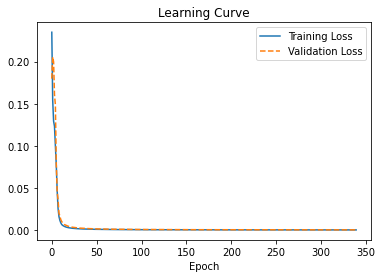

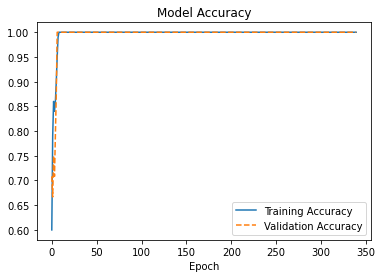

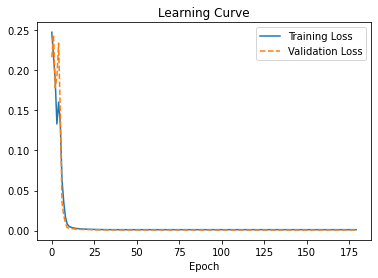

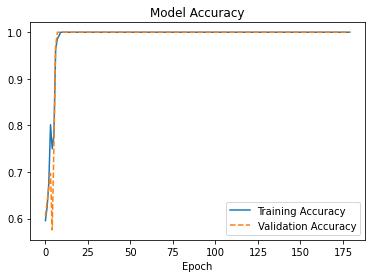

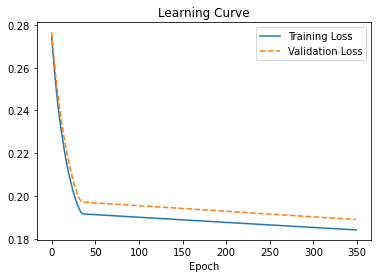

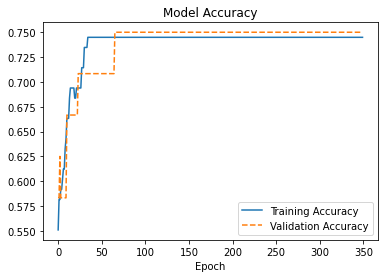

In [ ]:
# Iteration on all the Datasets
for dataset_i in range(datasets_number):

    # Print best hyperparameters
    print(f"\n### Best Hyperparameters for Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()

    # Plot the learning curve
    nn[dataset_i].print_plot()   

   
 
    # BEST L CURVE M1: >(semismoothed)
    # Hyperparameters:          {'input_units': 17, 'hidden_units': 5, 'patience': 100, 'factor_lr_dec': 0.5, 'step_decay': 1500, 'learning_rate': 0.999, 'batch_size': 17, 'epochs': 350, 'weight_init': 'glorot_normal', 'momentum': 0.4, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
    #  Hyperparameters:          {'input_units': 17, 'hidden_units': 5, 'patience': 100, 'factor_lr_dec': 0.5, 'step_decay': 1000, 'learning_rate': 0.5, 'batch_size': 32, 'epochs': 370, 'weight_init': 'lecun_normal', 'momentum': 0.8, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
    # Hyp:  {'input_units': 17, 'hidden_units': 5, 'patience': 200, 'factor_lr_dec': 0.5, 'step_decay': 500, 'learning_rate': 0.99, 'batch_size': 16, 'epochs': 530, 'weight_init': 'lecun_normal', 'momentum': 0.5, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
    
    # BEST SMOOTHED CURVE MONK1:   HyperparameterS: {'hidden_units': 4, 'patience': 30, 'learning_rate': 0.3, 'batch_size': 4, 'nesterov': 'T', 'epochs': 440, 'momentum': 0.6}
                                                     #Hyperparameters:          {'input_units': 17, 'hidden_units': 4, 'patience': 15, 'learning_rate': 0.3, 'batch_size': 4, 'nesterov': 'F', 'epochs': 440, 'momentum': 0.7, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}

   # BEST SMOOTHER PT2 MONK2:  {'hidden_units': 4, 'patience': 10, 'learning_rate': 0.4, 'batch_size': 6, 'nesterov': 'T', 'epochs': 450, 'momentum': 0.3, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}

    

'''
Best Hyperparameters for Monk 2
 Monk:                     2
 Trial:                    3
 Hyperparameters:          {'input_units': 17, 'hidden_units': 5, 'patience': 200, 'factor_lr_dec': 1.0, 'step_decay': 500, 'learning_rate': 0.999, 'batch_size': 60, 'epochs': 290, 'momentum': 0.75, 'nesterov': 'T', 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.0006283932307269424
 Mean Validation Loss:     0.004200904699973762
 Mean Training Accuracy:   1.0
 Mean Validation Accuracy: 1.0

### Best Hyperparameters for Monk 3 ###
 Monk:                     3
 Trial:                    14
 Hyperparameters:          {'input_units': 17, 'hidden_units': 2, 'patience': 30, 'factor_lr_dec': 1.0, 'step_decay': 1500, 'learning_rate': 0.07, 'batch_size': 7, 'epochs': 370, 'weight_decay': 0.002, 'momentum': 0.08, 'nesterov': 'T', 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.059438984096050265
 Mean Validation Loss:     0.07536792308092118
 Mean Training Accuracy:   0.9508310675621032
 Mean Validation Accuracy: 0.934333324432373

 '''

## Retraining Phase

In [ ]:
# Iterations on each Dataset
for dataset_i in range(datasets_number):

    # Training the model
    nn[dataset_i].fit(
        x_train=x_train[dataset_i].values,
        y_train=y_train[dataset_i].values
    )

    # Print values
    print(f"\n### Retraining of Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()

    


### Retraining of Monk 1 ###
 Monk:                     1
 Trial:                    3
 Hyperparameters:          {'hidden_units': 4, 'patience': 15, 'factor_lr_dec': 0.5, 'step_decay': 500, 'learning_rate': 0.9, 'batch_size': 10, 'epochs': 180, 'momentum': 0.6, 'nesterov': 'T'}
 Mean Training Loss:       0.008455383451655507
 Mean Validation Loss:     0.032863875920884314
 Mean Training Accuracy:   0.991919195652008
 Mean Validation Accuracy: 0.9600000023841858


IndexError: list index out of range

# Testing Phase


### Testing of Monk 1 ###
 Monk:                     1
 Trial:                    1
 Hyperparameters:          {'hidden_units': 4, 'patience': 15, 'factor_lr_dec': 0.5, 'step_decay': 500, 'learning_rate': 0.9, 'batch_size': 10, 'epochs': 180, 'momentum': 0.6, 'nesterov': 'T'}
 Mean Training Loss:       0.0022749395575374365
 Mean Validation Loss:     0.004029201343655586
 Mean Training Accuracy:   1.0
 Mean Validation Accuracy: 1.0




### Testing of Monk 1 ###
 Monk:                     1
 Trial:                    1
 Hyperparameters:          {'hidden_units': 4, 'patience': 15, 'factor_lr_dec': 0.5, 'step_decay': 500, 'learning_rate': 0.9, 'batch_size': 10, 'epochs': 180, 'momentum': 0.6, 'nesterov': 'T'}
 Mean Training Loss:       0.0229744192911312
 Mean Validation Loss:     0.02571279462426901
 Mean Training Accuracy:   0.9677419364452362
 Mean Validation Accuracy: 0.9583333432674408




### Testing of Monk 1 ###
 Monk:                     1
 Trial:                    1
 Hyperpar

IndexError: list index out of range

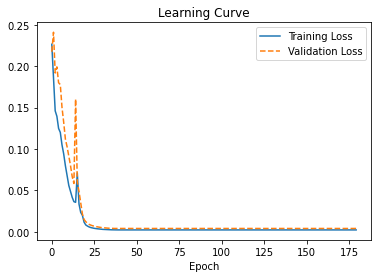

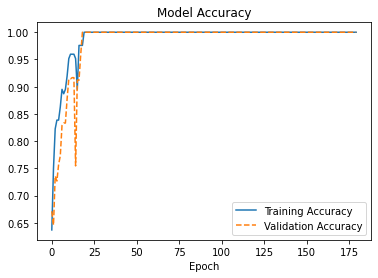

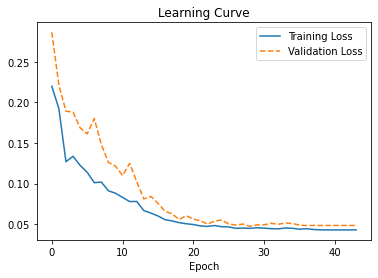

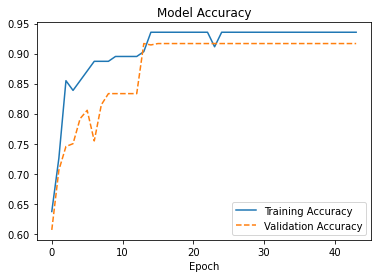

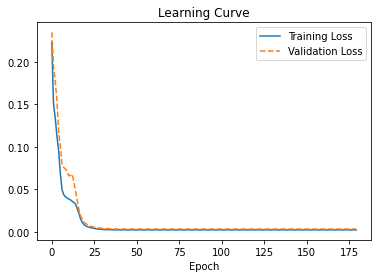

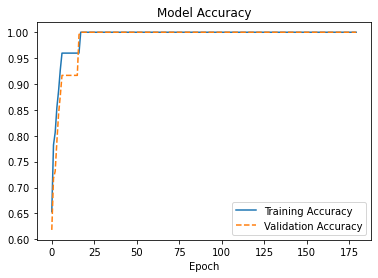

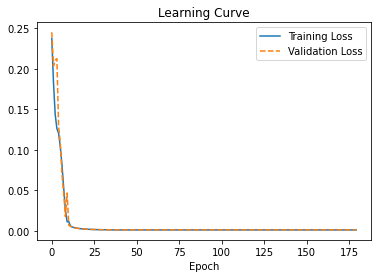

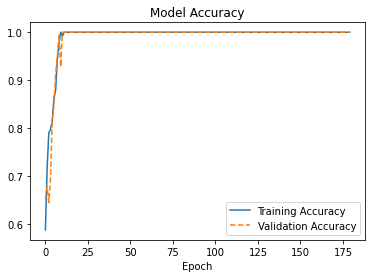

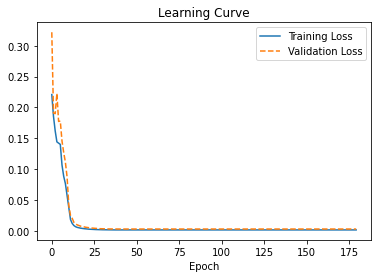

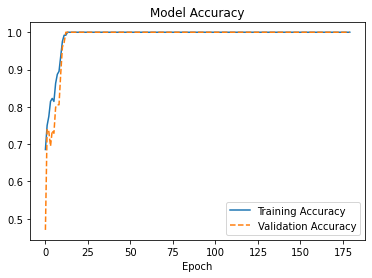

In [ ]:
# Evaluation of the Models for each Test set
for dataset_i in range(datasets_number):
    # Creation of the Neural Network object
        nn_i = BinaryNN(params=nn[dataset_i].params, monk_i=dataset_i+1, trial=i+1)
        x = x_train[dataset_i].values
        y_fit = y_train[dataset_i].values
        X = x_test[dataset_i].values
        y = y_test[dataset_i].values
    
        for i in range(1,6):

            # Building the model
            nn_i.create_model(n_hidden_layers=n_hidden_layers_list[dataset_i])

            # Training the model
            nn_i.fit( x_train=x,
                y_train=y_fit,
                x_val=X,
                y_val=y_test
                            )

            # Evaluating the model on test
            nn_i.evaluate(
                    x_train=x,
                    y_train=y_fit,
                    x_val=X,
                    y_val=y_test
                            )

            # Print values
            print(f"\n### Testing of Monk {dataset_i+1} ###")
            nn_i.print_training_info()
            print("\n\n")

            # Plot the learning curve
            nn_i.print_plot()  



 Monk:                     1
 Trial:                    3
 Hyperparameters:          {'hidden_units': 4, 'patience': 30, 'learning_rate': 0.3, 'batch_size': 4, 'nesterov': 'T', 'epochs': 240, 'momentum': 0.6}
 Mean Training Loss:       0.00015656252217013388
 Mean Validation Loss:     0.0015260230982676148
 Test Loss:                0.0005450468743219972
 Mean Training Accuracy:   1.0
 Mean Validation Accuracy: 1.0
 Test Accuracy:            1.0
 f1 score:                 1.0
 f2 score:                 1.0
 Precision score:         1.0
 Recall score:             1.0

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                216                  0
Real_Class_1                  0                216


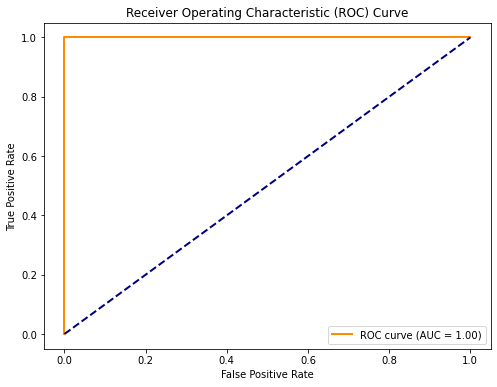

 Monk:                     2
 Trial:                    3
 Hyperparameters:          {'hidden_units': 4, 'patience': 15, 'factor_lr_dec': 0.5, 'step_decay': 500, 'learning_rate': 0.9, 'batch_size': 10, 'epochs': 180, 'momentum': 0.6, 'nesterov': 'T'}
 Mean Training Loss:       0.008727192098740488
 Mean Validation Loss:     0.009672029549255967
 Test Loss:                0.05480208992958069
 Mean Training Accuracy:   0.9926470637321472
 Mean Validation Accuracy: 0.9941176414489746
 Test Accuracy:            0.9444444179534912
 f1 score:                 0.922077922077922
 f2 score:                 0.9673024523160763
 Precision score:         0.8554216867469879
 Recall score:             1.0

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                266                 24
Real_Class_1                  0                142


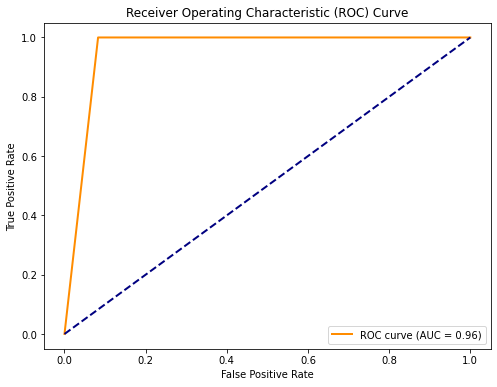

IndexError: list index out of range

In [ ]:

# Evaluation of the Models for each Test set
for dataset_i in range(datasets_number):
    X = x_test[dataset_i].values
    y = y_test[dataset_i].values

    # Evaluate the Model on TS set
    nn[dataset_i].test(
        x_test=X,
        y_test=y
    )

    # Computes the score of the Model
    nn[dataset_i].score(x_test=X, y_test=y)

    # Prints the results obtained
    print(nn[dataset_i])
    nn[dataset_i].print_confusion_matrix(y_test=y)
    nn[dataset_i].print_roc_curve(y_test=y)